First load libraries

In [1]:
from cobra.io import load_json_model, read_sbml_model, load_matlab_model
from cobra.flux_analysis import flux_variability_analysis
from cobra.flux_analysis import pfba

from dingo.utils import correlated_reactions
from dingo.utils import cluster_corr_reactions
from dingo.utils import graph_corr_matrix
from dingo.illustrations import plot_corr_matrix
from dingo.illustrations import plot_dendrogram
from dingo.illustrations import plot_graph
from dingo.preprocess import PreProcess
from dingo import MetabolicNetwork, PolytopeSampler

import numpy as np
from scipy.stats import spearmanr
import pickle



/home/touliopoulos/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/touliopoulos/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


Load models

In [2]:

#roseburia_dingo_model = MetabolicNetwork.from_mat("/home/touliopoulos/project/erasmus/code/data/Reconstructions_data/Roseburia_intestinalis_L1_82_withMucins.mat")
#roseburia_dingo_model = MetabolicNetwork.from_mat("/home/touliopoulos/project/erasmus/erasmus_2025_project/data/Reconstructions_data/Roseburia_intestinalis_L1_82_fixed.mat")
#roseburia_cobra_model = load_matlab_model("/home/touliopoulos/project/erasmus/erasmus_2025_project/data/Reconstructions_data/Roseburia_intestinalis_L1_82_fixed.mat")
roseburia_dingo_model = MetabolicNetwork.from_sbml("/home/touliopoulos/project/erasmus/erasmus_2025_project/data/Reconstructions_data/e_coli_core.xml")
reactions = roseburia_dingo_model.reactions


Set parameter Username
Academic license - for non-commercial use only - expires 2025-03-29


In [109]:
alan = roseburia_cobra_model.groups.get_by_id("Alanine and aspartate metabolism")

Now load sampling/correlation matrix data

In [114]:
alan.__dict__

{'_id': 'Alanine and aspartate metabolism',
 'name': 'Alanine and aspartate metabolism',
 'notes': {},
 '_annotation': {'sbo': 'SBO:0000633'},
 '_members': {<Reaction AGTi at 0x70a234130ca0>,
  <Reaction ALAALA at 0x70a22f3bc5b0>,
  <Reaction ALAR at 0x70a22e48e1d0>,
  <Reaction ARGSL at 0x70a22c66a560>,
  <Reaction ARGSS at 0x70a22c5b30a0>,
  <Reaction ASNS1 at 0x70a22c303700>,
  <Reaction ASNS2 at 0x70a22c5b2fe0>,
  <Reaction ASPT at 0x70a227f419f0>,
  <Reaction ASPTA at 0x70a227f41cf0>,
  <Reaction r0127 at 0x70a1e8ac6f20>},
 '_kind': 'partonomy',
 '_model': <Model model at 0x70a2470661a0>}

In [4]:
# load samples data
#with open("/home/touliopoulos/project/erasmus/erasmus_2025_project/RI_steady_states_opt_1.pckl", "rb") as steady_states:
with open("/home/touliopoulos/project/erasmus/erasmus_2025_project/EC_steady_states_opt_100.pckl", "rb") as steady_states:
    # steady_states = abs(pickle.load(steady_states))
    steady_states = pickle.load(steady_states)

    
# load correlation matrix data
#with open("/home/touliopoulos/project/erasmus/erasmus_2025_project/RI_corr_matrix_opt_1.pckl", "rb") as corr_matrix:
#    corr_matrix = pickle.load(corr_matrix)
    

#del steady_states


In [5]:
extended_steady_states = []
extended_reactions = []
for index, r in enumerate(steady_states):
    if (r < 0).any():
        s = abs(r)
        extended_steady_states.append(s)
        extended_reactions.append("_".join([reactions[index], "rev"]))
    
    extended_steady_states.append(r)
    extended_reactions.append(reactions[index])

In [6]:
extended_steady_states = np.array(extended_steady_states)

In [8]:
print(extended_reactions[3])
extended_steady_states[3,:]

PGK_rev


array([16.02353377, 16.02353562, 16.02352651, ..., 16.02352897,
       16.02352817, 16.02352759])

In [9]:
print(extended_reactions[4])
extended_steady_states[4,:]

PGK


array([-16.02353377, -16.02353562, -16.02352651, ..., -16.02352897,
       -16.02352817, -16.02352759])

In [44]:
PFK_INDEX = 0 
FBP_INDEX = 64

pfk_samples = steady_states[PFK_INDEX,:]
fbp_samples = steady_states[FBP_INDEX, :]

In [91]:
extended_steady_states.shape

(118, 4400)

In [53]:
pfk_samples.mean()

7.477386046761352

In [54]:
fbp_samples.mean()

4.09550039909527e-06

In [59]:
a = [-3, -4, -2, -5, -22]
b = [4, 5, 7, 5, 30]

np.corrcoef(a,b)

array([[ 1.        , -0.97949329],
       [-0.97949329,  1.        ]])

In [46]:
import matplotlib.pyplot as plt

(array([1.900e+01, 1.190e+02, 4.330e+02, 1.219e+03, 1.486e+03, 7.780e+02,
        2.510e+02, 7.500e+01, 1.900e+01, 1.000e+00]),
 array([7.4773613 , 7.47736707, 7.47737285, 7.47737862, 7.4773844 ,
        7.47739017, 7.47739595, 7.47740172, 7.4774075 , 7.47741327,
        7.47741905]),
 <BarContainer object of 10 artists>)

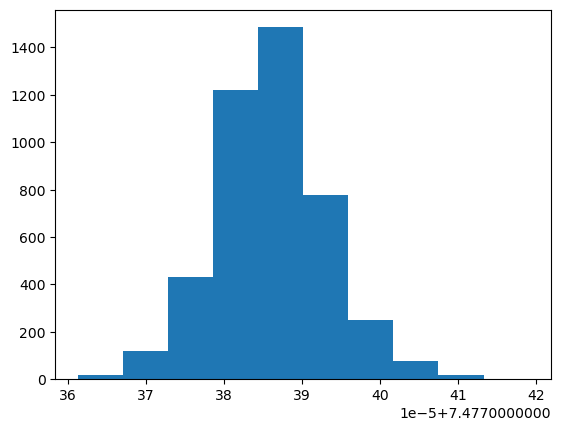

In [52]:
# plt.hist(fbp_samples)
plt.hist(pfk_samples)

In [50]:
np.corrcoef(fbp_samples, pfk_samples)

array([[1.        , 0.57320667],
       [0.57320667, 1.        ]])

Correlation Matrix and Clustering

In [123]:

# Remove NAs from corr matrix and find corresponding remaining reactions
#non_na_rows = ~np.all(np.isnan(corr_matrix), axis=1)
#filtered_corr_matrix = corr_matrix[non_na_rows][:, non_na_rows]
#filtered_corr_matrix = np.nan_to_num(filtered_corr_matrix, nan=0)
#filtered_reactions = [reaction for reaction, keep in zip(reactions, non_na_rows) if keep]


corr_matrix = np.corrcoef(steady_states, rowvar=True)
corr_matrix[np.isnan(corr_matrix)] = 0


#plot_corr_matrix(corr_matrix, reactions=reactions, format="svg")


dissimilarity_matrix_complete, labels_complete, clusters_complete = cluster_corr_reactions(
                                         corr_matrix,
                                         reactions = reactions,
                                         linkage = "complete",
                                         
                                         # 1
                                         t = 20.0,
                                         
                                         # 100
                                         #t = 50.0, 
                                         
                                         correction = False)

plot_dendrogram(dissimilarity_matrix_complete,
                reactions = reactions,
                plot_labels = False,     
                t = 0.0,     
                linkage = "complete")


dissimilarity_matrix_ward, labels_ward, clusters_ward = cluster_corr_reactions(
                                         corr_matrix,
                                         reactions = reactions,
                                         linkage = "ward",
                                         
                                         # 1
                                         t = 100.0,
                                         
                                         # 100
                                         #t = 400,
                                         
                                         correction = False)

plot_dendrogram(dissimilarity_matrix_ward,
                reactions = reactions,
                plot_labels = False,
                t = 0.0,
                linkage = "ward")


#del dissimilarity_matrix, labels, clusters




/home/touliopoulos/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2853: RuntimeWarning:

invalid value encountered in divide

/home/touliopoulos/.local/lib/python3.10/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning:

invalid value encountered in divide



# Extract clusters

In [130]:
"""
cluster_of_interest_1 = clusters_complete[0]
cluster_of_interest_2 = clusters_complete[1]
print(len(cluster_of_interest_1))
print(len(cluster_of_interest_2))

groups_of_interest = []

for group in roseburia_cobra_model.groups:
    group_count_1 = 0
    group_count_2 = 0
    for reaction in group.members:
        if str(reaction.id) in cluster_of_interest_1:
            group_count_1 += 1
        elif str(reaction.id) in cluster_of_interest_2:
            group_count_2 += 1
            
    if group_count_1 != 0 and group_count_2 != 0:
        scaled_group_count_1 = group_count_1/len(cluster_of_interest_1)
        scaled_group_count_2 = group_count_2/len(cluster_of_interest_2)      
        if ( (scaled_group_count_1 / scaled_group_count_2) > 4):
            groups_of_interest.append(group)
            print(group, round(scaled_group_count_1*100, 2), round(scaled_group_count_2*100, 2))


print("\n")
"""

cluster_of_interest_1 = clusters_ward[0]
cluster_of_interest_2 = clusters_ward[1]
print(len(cluster_of_interest_1))
print(len(cluster_of_interest_2))

groups_of_interest = []


for group in roseburia_cobra_model.groups:

    group_count_1 = 0
    group_count_2 = 0

    for reaction in group.members:
        if str(reaction.id) in cluster_of_interest_1:
            group_count_1 += 1
        elif str(reaction.id) in cluster_of_interest_2:
            group_count_2 += 1
            
    if group_count_1 != 0 and group_count_2 != 0:
        print(group_count_1, group_count_2, len(group.members))
        scaled_group_count_1 = group_count_1*100/len(group.members)
        scaled_group_count_2 = group_count_2*100/len(group.members)
        #if ( (scaled_group_count_1 / scaled_group_count_2) > 4):
        groups_of_interest.append(group)
        print(group, round(scaled_group_count_1, 2), round(scaled_group_count_2, 2) )




259
2686
2 8 10
Alanine and aspartate metabolism 20.0 80.0
7 9 16
Aminosugar metabolism 43.75 56.25
5 11 16
Arginine and proline metabolism 31.25 68.75
4 2 6
Biotin metabolism 66.67 33.33
3 3 6
Butanoate metabolism 50.0 50.0
20 23 43
Cell wall biosynthesis 46.51 53.49
2 1 3
Cholesterol metabolism 66.67 33.33
2 2 4
Citric acid cycle 50.0 50.0
10 1 11
CoA synthesis 90.91 9.09
1 174 175
Drug metabolism 0.57 99.43
23 863 886
Exchange/demand reaction 2.6 97.4
1 101 102
Fatty acid synthesis 0.98 99.02
3 9 12
Folate metabolism 25.0 75.0
1 8 9
Fructose and mannose metabolism 11.11 88.89
3 3 6
Galactose metabolism 50.0 50.0
2 4 6
Glutamate metabolism 33.33 66.67
4 140 144
Glycerophospholipid metabolism 2.78 97.22
2 12 14
Glycine, serine, alanine, and threonine metabolism 14.29 85.71
5 22 27
Glycolysis/gluconeogenesis 18.52 81.48
10 1 11
Histidine metabolism 90.91 9.09
1 1 2
Lipopolysaccharide biosynthesis 50.0 50.0
3 7 10
Lysine metabolism 30.0 70.0
1 16 17
Methionine and cysteine metabolism 5.

In [145]:
for r in roseburia_cobra_model.groups.get_by_id("Butanoate metabolism").members:
    print(r.id)

FDNADOX_H
3HBCOAE
PHPB2i
BTCOAACCOAT
ACOAD1i
BTCOADH


In [141]:
roseburia_cobra_model.reactions.BTCOAACCOAT

Reaction identifier,BTCOAACCOAT
Name,Butyryl-CoA:acetate CoA-transferase
Memory address,0x70a20a3c0a90
Stoichiometry,ac[c] + btcoa[c] --> accoa[c] + but[c] Acetate + Butanoyl-CoA --> Acetyl-CoA + Butyrate
GPR,
Lower bound,0.0
Upper bound,1000.0


In [138]:
roseburia_cobra_model.reactions.ACOAD1i


Reaction identifier,ACOAD1i
Name,acyl-CoA dehydrogenase (butanoyl-CoA)
Memory address,0x70a23f78cb50
Stoichiometry,b2coa[c] + h[c] + nadh[c] --> btcoa[c] + nad[c] crotonoyl-CoA(4-) + proton + Nicotinamide adenine dinucleotide - reduced --> Butanoyl-CoA + Nicotinamide adenine dinucleotide
GPR,ROSINTL182_05032
Lower bound,0.0
Upper bound,1000.0


In [142]:
roseburia_cobra_model.reactions.BTCOADH

Reaction identifier,BTCOADH
Name,Conversion of crotonoyl-CoA to butyryl-CoA by Bcd-Etf complex
Memory address,0x70a20a3c0970
Stoichiometry,b2coa[c] + fdxox[c] + 2.0 h[c] + 2.0 nadh[c] <=> btcoa[c] + fdxrd[c] + 2.0 nad[c] crotonoyl-CoA(4-) + Oxidized ferredoxin + 2.0 proton + 2.0 Nicotinamide adenine dinucleotide - reduced <=> Butanoyl-CoA + Reduced ferredoxin + 2.0 Nicotinamide adenine dinucleotide
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [143]:
roseburia_cobra_model.reactions.FDNADOX_H

Reaction identifier,FDNADOX_H
Name,"Ferredoxin:NAD oxidoreductase, generating a proton motive force"
Memory address,0x70a2029b8a00
Stoichiometry,fdxrd[c] + nad[c] <=> fdxox[c] + h[e] + nadh[c] Reduced ferredoxin + Nicotinamide adenine dinucleotide <=> Oxidized ferredoxin + proton + Nicotinamide adenine dinucleotide - reduced
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [144]:
roseburia_cobra_model.reactions.get_by_id("3HBCOAE")

Reaction identifier,3HBCOAE
Name,(S)-3-Hydroxybutanoyl-coa[c] 3-epimerase
Memory address,0x70a246addb70
Stoichiometry,3hbcoa[c] <=> 3hbcoa_R[c] (S)-3-hydroxybutanoyl-CoA(4-) <=> (R)-3-hydroxybutanoyl-CoA(4-)
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [151]:
but = ["FDNADOX_H",
"3HBCOAE",
"PHPB2i",
"BTCOAACCOAT",
"ACOAD1i",
"BTCOADH"
]
but_copy = but.copy()

for r in clusters_ward[0]:
    if r in but:

        print(r)
        print(roseburia_cobra_model.reactions.get_by_id(r).build_reaction_string())
        but.remove(r)

3HBCOAE
3hbcoa[c] <=> 3hbcoa_R[c]
ACOAD1i
b2coa[c] + h[c] + nadh[c] --> btcoa[c] + nad[c]
PHPB2i
aacoa[c] + h[c] + nadph[c] --> 3hbcoa[c] + nadp[c]


In [163]:
for r in but:
    print(r)
    print(roseburia_cobra_model.reactions.get_by_id(r).build_reaction_string())

FDNADOX_H
fdxrd[c] + nad[c] <=> fdxox[c] + h[e] + nadh[c]
BTCOAACCOAT
ac[c] + btcoa[c] --> accoa[c] + but[c]
BTCOADH
b2coa[c] + fdxox[c] + 2.0 h[c] + 2.0 nadh[c] <=> btcoa[c] + fdxrd[c] + 2.0 nad[c]


In [192]:
cluster1 = ["ACOAD1i","PHPB2i", "3HBCOAE"]

index_p = roseburia_dingo_model.reactions.index("ACOAD1i")  # cluster 2
p = steady_states[index_p,:]


index_q = roseburia_dingo_model.reactions.index("PHPB2i")  # cluster 2
q = steady_states[index_q,:]


index_r = roseburia_dingo_model.reactions.index("3HBCOAE")  # cluster 2
r = steady_states[index_r,:]



cluster2=["FDNADOX_H","BTCOAACCOAT","BTCOADH"]

indexx = roseburia_dingo_model.reactions.index("FDNADOX_H") # cluster 1
x = steady_states[indexx,:]

indexx = roseburia_dingo_model.reactions.index("BTCOAACCOAT") # cluster 1
y = steady_states[indexx,:]

indexx = roseburia_dingo_model.reactions.index("BTCOADH") # cluster 1
z = steady_states[indexx,:]


In [166]:
import dingo

In [188]:

for index_i, i in enumerate([x,y,z]):
    for index_j, j in enumerate([p,q,r]):
        print(cluster1[index_i], cluster2[index_j])
        print(np.corrcoef(i,j))

ACOAD1i FDNADOX_H
[[ 1.         -0.07899709]
 [-0.07899709  1.        ]]
ACOAD1i BTCOAACCOAT
[[1.         0.02121787]
 [0.02121787 1.        ]]
ACOAD1i BTCOADH
[[1.         0.02573701]
 [0.02573701 1.        ]]
PHPB2i FDNADOX_H
[[1.         0.33675228]
 [0.33675228 1.        ]]
PHPB2i BTCOAACCOAT
[[1.         0.21646331]
 [0.21646331 1.        ]]
PHPB2i BTCOADH
[[1.         0.25161784]
 [0.25161784 1.        ]]
3HBCOAE FDNADOX_H
[[ 1.         -0.99476994]
 [-0.99476994  1.        ]]
3HBCOAE BTCOAACCOAT
[[ 1.         -0.61308459]
 [-0.61308459  1.        ]]
3HBCOAE BTCOADH
[[ 1.         -0.61377918]
 [-0.61377918  1.        ]]


In [195]:
for i in [x,y,z]:
    for j in [x,y,z]:
        print(np.corrcoef(i,j))

[[1. 1.]
 [1. 1.]]
[[1.         0.02750965]
 [0.02750965 1.        ]]
[[1.         0.08445384]
 [0.08445384 1.        ]]
[[1.         0.02750965]
 [0.02750965 1.        ]]
[[1. 1.]
 [1. 1.]]
[[ 1.         -0.23881586]
 [-0.23881586  1.        ]]
[[1.         0.08445384]
 [0.08445384 1.        ]]
[[ 1.         -0.23881586]
 [-0.23881586  1.        ]]
[[1. 1.]
 [1. 1.]]


In [193]:
corr_matrix[index_p, index_q]

0.6172461853292088